# CIFAR-10 CNN

CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

O conjunto de dados CIFAR-10 possui 60.000 imagens coloridas de dimensões $32\times 32$. Os dados são divididos em 10 classes com 6.000 imagens por classe. 

No exemplo abaixo nós utilizamos apenas 3 das 10 classes. A saída das diferentes camadas da CNN são mostradas.

## Importando as bibliotecas

In [52]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pylab as plt
from collections import OrderedDict

# from torch
import torch
import torch.nn as nn
from torch.autograd import Variable

# from torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

In [53]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Carregando e mostrando os dados (seleciona apenas as classes 0, 1 e 2)

In [6]:
from torchvision.datasets import CIFAR10

CIFAR_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class CIFARX(CIFAR10):
    def __init__(self, root, classes, train=True, **kwargs):
        super(CIFARX, self).__init__(root, train, **kwargs)
        
        # check wrong parameters
        if not isinstance(classes, list):
            raise Exception('Argument classes must be a list')
        
        if max(classes) > 9 or min(classes) < 0:
            raise Exception('Value of elements in classes must be in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]')
        
        new_data = []
        new_labels = []
        if train:
            lbs = self.train_labels
            train_idxs = ()
            
            for i, label in enumerate(self.train_labels):
                if label in classes:
                    new_data.append(self.train_data[i])
                    new_labels.append(label)
                    
            new_data = np.array(new_data)
            self.train_data = new_data
            self.train_labels = new_labels
        else:  # test set
            for i, label in enumerate(self.test_labels):
                if label in classes:
                    new_data.append(self.test_data[i])
                    new_labels.append(label)

            new_data = np.array(new_data)
            self.test_data = new_data
            self.test_labels = new_labels           
        
        self.classes = np.array(CIFAR_CLASSES)[classes]

In [66]:
from functools import reduce
a = np.array([0, 1, 2, 2, 1, 1])
b = [1, 2]
print(reduce(lambda x, y: x | (a==y), b))

[1 1 1 1 1 1]


In [7]:
images_dir = '/data/datasets/CIFAR10/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados são normalizados)
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    'train': CIFARX(images_dir, [0, 1, 2], train=True, transform=data_transforms['train'], download=True),
    'val': CIFARX(images_dir, [0, 1, 2], train=False, transform=data_transforms['val'], download=True),
}

print('amostras para treinamento:', len(image_datasets['train']))
print('amostras para validação:', len(image_datasets['val']))

Files already downloaded and verified
Files already downloaded and verified
amostras para treinamento: 15000
amostras para validação: 3000


In [56]:
print(type(image_datasets['val'].test_data))

<class 'numpy.ndarray'>


## Mostrando algumas imagens do conjunto de teste

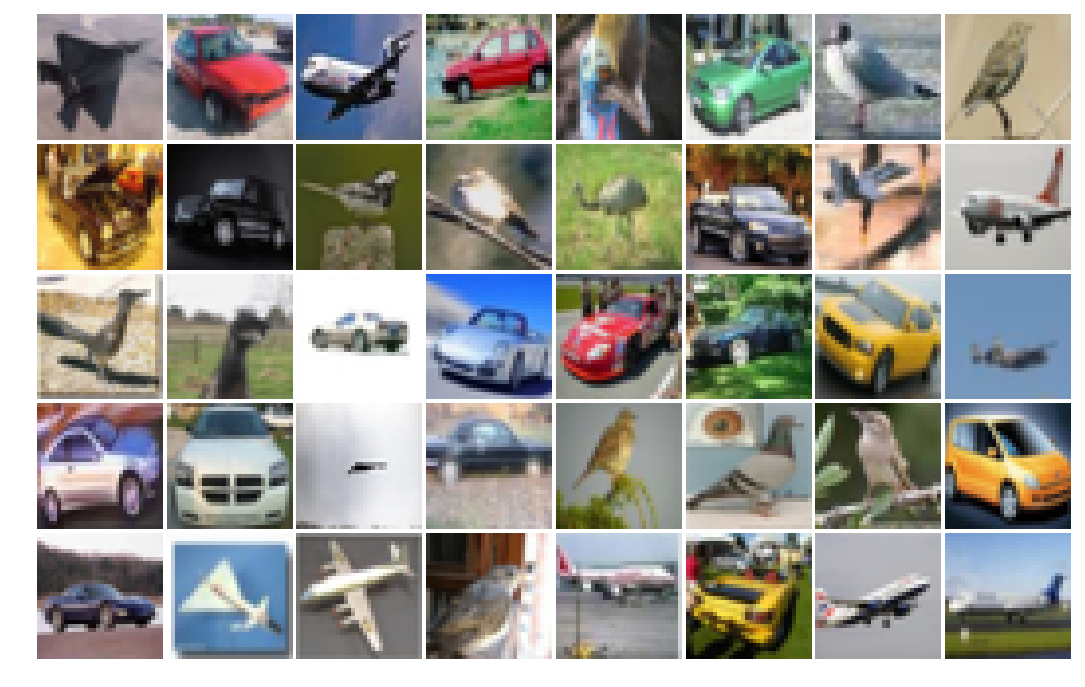

In [5]:
plt.figure(figsize=(24, 12))
n_samples = 40

# cria um DataLoader temporario para mostrar as imagens
temp_dataloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=n_samples,
                                              shuffle=True, num_workers=4)

# cria um grid com as imagens
grid = torchvision.utils.make_grid(next(iter(temp_dataloader))[0], normalize=True, pad_value=1.0, padding=1)

plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Teste inicial com pouquíssimas amostras

In [6]:
testing = False
if testing:
    n_samples = np.int(2*1280*(1+0.34))
    image_datasets['train'].train_data = image_datasets['train'].train_data[:n_samples]
    image_datasets['train'].train_labels = image_datasets['train'].train_labels[:n_samples]
    
    n_samples_test = 500
    image_datasets['val'].test_data = image_datasets['val'].test_data[:n_samples_test]
    image_datasets['val'].test_labels = image_datasets['val'].test_labels[:n_samples_test]

## Cria o DataLoader para os dados

In [15]:
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=4)
                                             for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print('Tamanho do conjunto de treinamento:', dataset_sizes['train'])
print('Tamanho do conjunto de validacao:', dataset_sizes['val'])
print('Classes:', class_names)

Tamanho do conjunto de treinamento: 15000
Tamanho do conjunto de validacao: 3000
Classes: ['airplane' 'automobile' 'bird']


# Construíndo a CNN com o PyTorch

In [14]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', nn.ReLU()),
            ('max_pool', nn.MaxPool2d(2)),
            ('drop', nn.Dropout(p=0.25))
        ]))
        
        # Camadas densas
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(in_features=14*14*32, out_features=128)),
            ('relu1', nn.ReLU()),
            ('drop1', nn.Dropout(p=0.5)),
            ('dense2', nn.Linear(in_features=128, out_features=3)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 14*14*32)  # Transforma a matriz em vetor
        x = self.dense_layer(x)
        
        return x

In [17]:
model = MyModel()
print(model)

MyModel (
  (conv_layer): Sequential (
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU ()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU ()
    (max_pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (drop): Dropout (p = 0.25)
  )
  (dense_layer): Sequential (
    (dense1): Linear (6272 -> 128)
    (relu1): ReLU ()
    (drop1): Dropout (p = 0.5)
    (dense2): Linear (128 -> 3)
  )
)


## Código de apoio ao treinamento

In [18]:
class DeepNetTrainer:
    
    def __init__(self, file_basename=None, model=None, criterion=None, metrics=None, 
                 optimizer=None, lr_scheduler=None, reset=False):
        assert (model is not None) and (criterion is not None) and (optimizer is not None)
        self.basename = file_basename
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = lr_scheduler
        self.metrics = dict(train=dict(losses=[]), valid=dict(losses=[]))
        self.compute_metric = dict()
        
        if metrics is not None:
            for name, funct in metrics.items():
                self.metrics['train'][name] = []
                self.metrics['valid'][name] = []
                self.compute_metric[name] = funct
        
        if (self.basename is not None) and (not reset) and (os.path.isfile(self.basename + '.model')):
            self.load_trainer_state(self.basename, self.model, self.optimizer, self.metrics)
            print('Model loaded from', self.basename + '.model')
            
        self.last_epoch = len(self.metrics['train']['losses'])
        if self.scheduler is not None:
            self.scheduler.last_epoch = self.last_epoch
            
    def fit(self, n_epochs, train_data, valid_data=None):
        data = dict(train=train_data, valid=valid_data)
        if valid_data is None:
            phases = [('train', True)]
        else:
            phases = [('train', True), ('valid', False)]
            
        try:
            best_model = copy.deepcopy(model)
            best_loss = 1e10
            best_epoch = self.last_epoch

            print('Starting training for {} epochs'.format(n_epochs))
            for i in range(self.last_epoch + 1, self.last_epoch + n_epochs + 1):
                t0 = time.time()
                
                for phase, is_train in phases:
                
                    epo_samp = 0
                    epo_loss = 0
                    epo_metrics = dict([(n, 0) for n in self.compute_metric.keys()])
                    
                    self.model.train(is_train)
                    if is_train:
                        self.scheduler.step()

                    for ii, (X, Y) in enumerate(data[phase]):
                        if use_gpu:
                            X, Y = Variable(X.cuda()), Variable(Y.cuda())
                        else:
                            X, Y = Variable(X), Variable(Y)

                        Ypred = model.forward(X)
                        loss = self.criterion(Ypred, Y)
                        if is_train:
                            self.optimizer.zero_grad()
                            loss.backward()
                            self.optimizer.step()

                        epo_loss += loss.data.cpu().numpy()
                        epo_samp += 1

                        for name, fun in self.compute_metric.items():
                            metric = fun(Ypred.data, Y.data)
                            epo_metrics[name] += metric

                    eloss = float(epo_loss / epo_samp)
                    self.metrics[phase]['losses'].append(eloss)
                    
                    for name, fun in self.compute_metric.items():
                        metric = float(epo_metrics[name] / epo_samp)
                        self.metrics[phase][name].append(metric)

                if valid_data is None:
                    self.metrics['valid']['losses'].append(None)
                    for name, fun in self.compute_metric.items():
                        self.metrics['valid'][name].append(None)
                        
                is_best = ''
                if eloss < best_loss:
                    is_best = 'best'
                    best_loss = eloss
                    best_epoch = i
                    best_model = copy.deepcopy(model)
                    if self.basename is not None:
                        self.save_trainer_state(self.basename, self.model, self.optimizer, self.metrics)

                if (valid_data is not None) and (len(self.compute_metric) > 0):
                    # validation and metrics
                    mtrc = list(self.compute_metric.keys())[0]
                    print('{:3d}: {:5.1f}s  T: {:10.5f} {:5.2f}  V: {:10.5f} {:5.2f} {}'
                          .format(i, time.time() - t0, 
                                  self.metrics['train']['losses'][-1], self.metrics['train'][mtrc][-1],
                                  self.metrics['valid']['losses'][-1], self.metrics['valid'][mtrc][-1], is_best))
                elif (valid_data is not None):
                    # validation and no metrics
                    print('{:3d}: {:5.1f}s  T: {:10.5f}  V: {:10.5f} {}'
                          .format(i, time.time() - t0, self.metrics['train']['losses'][-1], 
                                                       self.metrics['valid']['losses'][-1], is_best))
                elif (valid_data is None) and (len(self.compute_metric) > 0):
                    # no validation and metrics
                    mtrc = list(self.compute_metric.keys())[0]
                    print('{:3d}: {:5.1f}s  T: {:10.5f} {:5.2f} {}'
                          .format(i, time.time() - t0, self.metrics['train']['losses'][-1], 
                                                       self.metrics['train'][mtrc][-1], is_best))
                else:
                    # no validation and no metrics
                    print('{:3d}: {:5.1f}s  T: {:10.5f} {}'
                          .format(i, time.time() - t0, self.metrics['train']['losses'][-1], is_best))
                
                t0 = time.time()

        except KeyboardInterrupt:
            print('Interrupted!!')

        print('\nModel from epoch {} saved as {}.*, loss = {:.5f}'.format(best_epoch, self.basename, best_loss))

    @staticmethod
    def load_trainer_state(file_basename, model, optimizer, metrics):
        model.load_state_dict(torch.load(file_basename + '.model'))
        if os.path.isfile(file_basename + '.optim'):
            optimizer.load_state_dict(torch.load(file_basename + '.optim'))
        if os.path.isfile(file_basename + '.histo'):
            metrics.update(pickle.load(open(file_basename + '.histo', 'rb')))
    
    @staticmethod
    def save_trainer_state(file_basename, model, optimizer, metrics):
        torch.save(model.state_dict(), file_basename + '.model')
        torch.save(optimizer.state_dict(), file_basename + '.optim')
        pickle.dump(metrics, open(file_basename + '.histo', 'wb'))

## Treinamento da rede

In [45]:
model = MyModel()
if use_gpu:
    model = model.cuda()
    
# Calcula o erro pela CrossEntropy
criterion = nn.CrossEntropyLoss()
# Otimizador
optimizer = torch.optim.Adam(model.parameters())
# Diminui o valor de lr por um fator de 0.1 a cada 7 epocas
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def accuracy(out, y):
    _, y_hat = torch.max(out, 1)
    return torch.sum(y_hat==y)/y_hat.size(0)

metrics = {'acc': accuracy}

trainer = DeepNetTrainer(file_basename='../data/cifar_1', 
                         model=model, 
                         criterion=criterion, 
                         optimizer=optimizer, 
                         lr_scheduler=exp_lr_scheduler,
                         metrics=metrics,
                         reset=True)

In [46]:
trainer.fit(n_epochs=25, train_data=dataloders['train'], valid_data=dataloders['val'])

Starting training for 25 epochs
  1:   1.0s  T:    0.70054  0.70  V:    0.49939  0.80 best
  2:   1.0s  T:    0.50379  0.80  V:    0.42679  0.84 best
  3:   1.1s  T:    0.44607  0.82  V:    0.38555  0.85 best
  4:   1.0s  T:    0.39440  0.84  V:    0.35259  0.86 best
  5:   1.0s  T:    0.36920  0.86  V:    0.35163  0.86 best
  6:   1.0s  T:    0.33966  0.87  V:    0.32261  0.87 best
  7:   1.0s  T:    0.29637  0.89  V:    0.30443  0.88 best
  8:   1.0s  T:    0.28746  0.89  V:    0.30227  0.88 best
  9:   1.0s  T:    0.28071  0.89  V:    0.29654  0.88 best
 10:   1.0s  T:    0.28032  0.89  V:    0.29824  0.88 
 11:   1.0s  T:    0.27363  0.90  V:    0.29774  0.88 
 12:   1.0s  T:    0.27008  0.90  V:    0.29430  0.89 best
 13:   1.0s  T:    0.26721  0.90  V:    0.29314  0.89 best
 14:   1.1s  T:    0.25975  0.90  V:    0.29184  0.89 best
 15:   1.0s  T:    0.26224  0.90  V:    0.29114  0.89 best
 16:   1.0s  T:    0.26234  0.90  V:    0.29117  0.89 
 17:   1.0s  T:    0.25846  0.90  V:

## Avaliação do treinamento no conjunto de testes

In [131]:
def test_network(model, dataset, criterion):
    temp_dataloader = torch.utils.data.DataLoader(dataset, batch_size=100,
                                                  shuffle=False, num_workers=4)
    
    model.train(False)
    
    loss_sum = 0.0
    hit_sum = 0.0
    all_preds = np.zeros(len(dataset)).astype(int)
    all_probs = np.zeros(len(dataset)).astype(float)
    for i, data in enumerate(temp_dataloader):
        inputs, labels = data
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
    
        outputs = model(inputs)
        loss_sum += criterion(outputs, labels)

        outputs = nn.functional.softmax(outputs)
        probs, preds = torch.max(outputs, 1)
        curr_img_index = i*temp_dataloader.batch_size
        all_preds[curr_img_index:curr_img_index+labels.size(0)] = preds.data.cpu().numpy()
        all_probs[curr_img_index:curr_img_index+labels.size(0)] = probs.data.cpu().numpy()
        hit_sum += torch.sum(preds.data==labels.data)
    
    loss = loss_sum.data.cpu()[0] / len(temp_dataloader)
    accuracy = hit_sum / len(dataset)
    
    print("\nAccuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))
    return (all_preds, all_probs)

In [132]:
y_hat, y_prob = test_network(model, image_datasets['val'], criterion)


Accuracy on the test data set: 88.90% [0.29052]


In [133]:
print('Rótulos conj. teste:', image_datasets['val'].test_labels[:10])
print('Rótulos previstos:  ',y_hat.tolist()[:10])
print('probabilidades:\n', y_prob.tolist()[:10])

Rótulos conj. teste: [0, 1, 1, 0, 0, 2, 0, 2, 1, 0]
Rótulos previstos:   [0, 1, 1, 0, 0, 2, 2, 1, 1, 0]
probabilidades:
 [0.9722083210945129, 0.9404504299163818, 0.9990869760513306, 0.8993378281593323, 0.8789949417114258, 0.996335506439209, 0.5916464924812317, 0.7686412930488586, 0.5415361523628235, 0.9701164960861206]


In [134]:
acc = (y_hat == image_datasets['val'].test_labels).sum()/y_hat.size
print('Acurácia:', acc)

Acurácia: 0.889


In [9]:
y_test = image_datasets['val'].test_labels
X_test = image_datasets['val'].test_data

## Predições certas com maior probabilidade

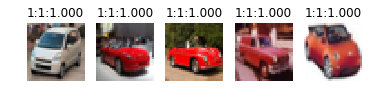

In [139]:
i_ok = np.where(y_hat==y_test)[0]
top_most_ok = np.argsort(y_prob[i_ok])[-5:][::-1]
y_top5 = i_ok[top_most_ok]

for k,i in enumerate(y_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i])
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições certas com menor probabilidade

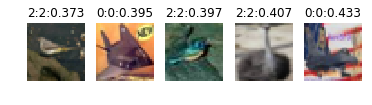

In [141]:
i_ok = np.where(y_hat==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
for k,i in enumerate(y_bot5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i])
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com maior probabilidade

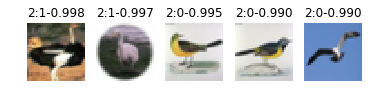

In [142]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_most_not_ok = np.argsort(y_prob[i_not_ok])[-5:][::-1]
y_most_not_ok_top5 = i_not_ok[top_most_not_ok]

for k,i in enumerate(y_most_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i])
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com menor probabilidade

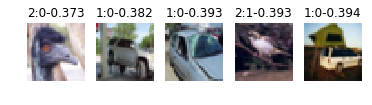

In [143]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_least_not_ok = np.argsort(y_prob[i_not_ok])[:5]
y_least_not_ok_top5 = i_not_ok[top_least_not_ok]

for k,i in enumerate(y_least_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i])
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Visualização de uma amostra

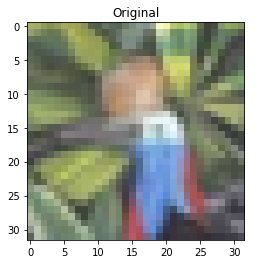

In [49]:
sn = 67  # amostra de número 70
plt.figure()
plt.imshow(X_test[sn])
#plt.axis('off')
plt.title("Original");

## Visualização das camadas internas

In [50]:
model = MyModel()
model.load_state_dict(torch.load('../data/cifar_1.model'))
model = model.cpu()

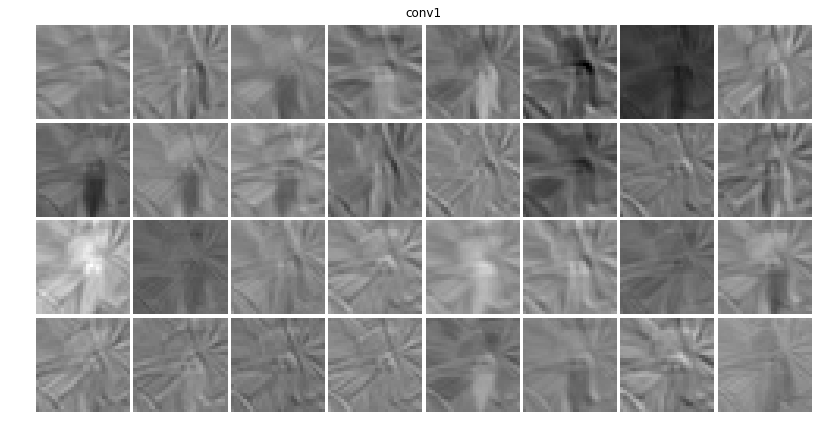

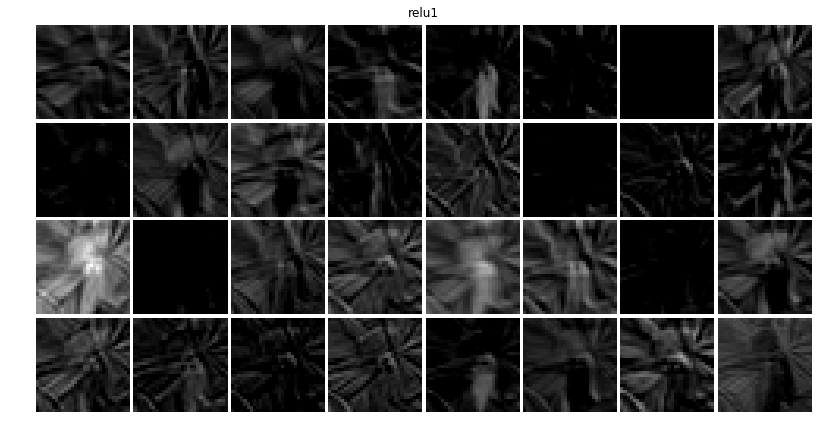

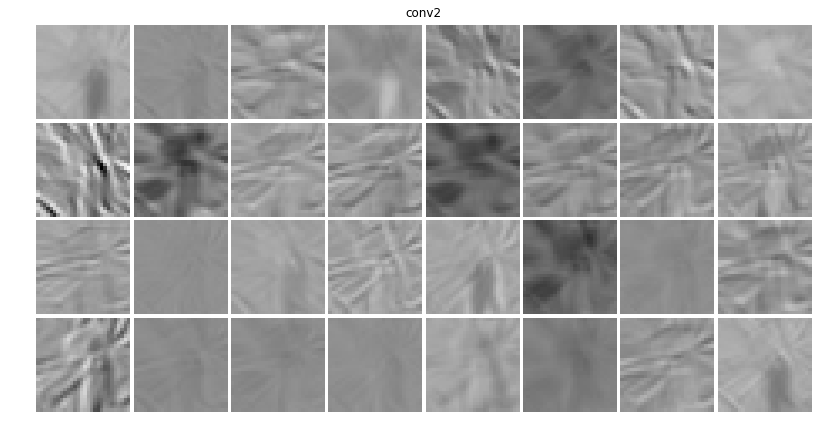

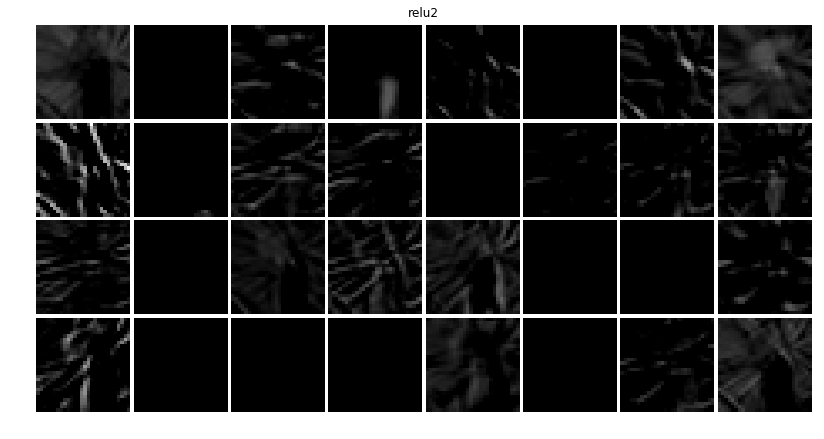

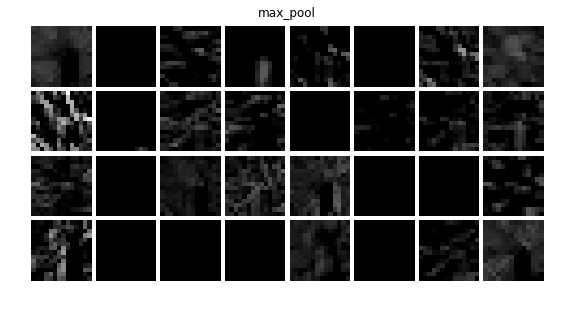

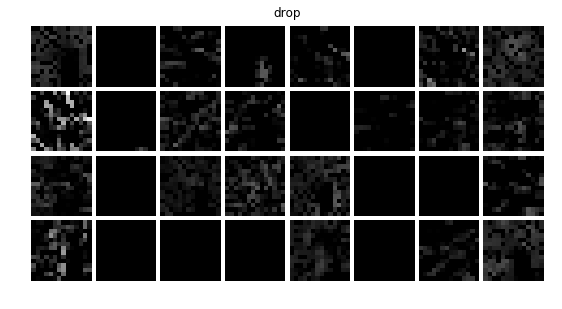

In [51]:
ncols = 8
H,W = 14,30

input, _ = image_datasets['val'][sn]
input = input.view(1, 3, 32, 32)

x = Variable(input)

model.train(True)

#Mostrando a saida das camadas convolucionais
for name, layer in model.conv_layer.named_children():
    x = layer(x)
    
    grid = torchvision.utils.make_grid(torch.transpose(x.data, 0, 1), normalize=True, 
                                       pad_value=1.0, padding=1).cpu().numpy()
    
    if name == 'max_pool':
        H /= 3/2
        W /= 3/2
    fig = plt.figure(figsize=(H,W))
    plt.imshow(grid.transpose((1,2,0)))
    plt.title(name)
    plt.axis('off')
    plt.show()


## Atividades

1. Quantos parâmetros são treinados nesta rede? Calcule o número de parâmetros de cada camada, não se esquecendo do *bias*. Confira o valor calculado com o `summary` do Keras.
2. Se as duas camadas convolucionais fossem densas, qual seria o número de parâmetros a serem treinados?
3. Altere o notebook para que ele seja processado na formato de imagens "channels_last".

## Aprendizados com este experimento
